<a href="https://colab.research.google.com/github/jx-dohwan/Deep_Learning_from_Scratch_2_study/blob/main/CH7_RNN%EC%9D%84_%EC%82%AC%EC%9A%A9%ED%95%9C_%EB%AC%B8%EC%9E%A5_%EC%83%9D%EC%84%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# CH7_RNN을 사용한 문장 생성
> 이번 장에서는 언어 모델을 사용해 '문장 생성'을 수행한다. 구체적으로는 우선 말뭉치를 사용해 학습한 언어 모델을 이용하여 샐운 문장을 만들어 낸다. 그런 다음 개선된 언어 모델을 이용하여 더 자연스러운 문장을 생성하는 모습을 선보이겠다. 여기까지 해보면 AI로 글을 쓰게 한다라는 개념을 실감할 수 있을 것이다.<br><br> 여기서 멈추지 않고 seq2seq라는 새고운 구조의 싱경망도 다룬다. 시계열에서 시계열로 라는 뜻으로 한 시계열 데이터를 다른 시계열 데이터로 변환하는 것을 말한다. 이 seq2seq는 기계번역, 챗봇, 메일의 자동 답신 등 다양하게 응용될 수 있다.

## 1. 언어 모델을 사용한 문장 생성

### 1) RNN을 사용한 문장 생성의 순서

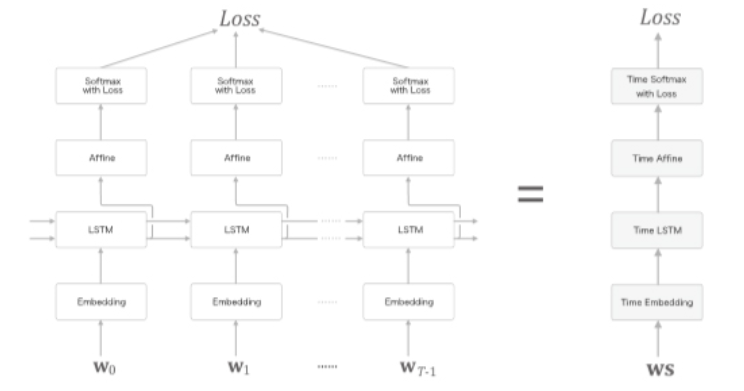

### 2) 문장 생성 구현

In [2]:
import sys
sys.path.append('/content/drive/MyDrive/인공지능/밑시딥2/')
import numpy as np
from common.functions import softmax
from rnnlm import Rnnlm
from better_rnnlm import BetterRnnlm

class RnnlmGen(Rnnlm):
  def generate(self, start_id, skip_ids = None, sample_size=100):
    word_ids = [start_id] # 최초로 주는 단어의 ID

    x = start_id 
    while len(word_ids) < sample_size:
      x = np.array(x).reshape(1,1)
      score = self.predict(x)
      p = softmax(score.flatten())

      sampled = np.random.choice(len(p), size=1, p=p)
      if (skip_ids is None) or (sampled not in skip_ids): # skip_id는 단어 ID의 리스트
        x = sampled
        word_ids.append(int(x))

    return 

In [3]:
import sys
sys.path.append('/content/drive/MyDrive/인공지능/밑시딥2/')
from rnnlm_gen import RnnlmGen
from dataset import ptb


corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)

model = RnnlmGen()
model.load_params('/content/drive/MyDrive/인공지능/밑시딥2/Rnnlm.pkl')

# start 문자와 skip 문자 설정
start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]
# 문장 생성
word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids]) # 단어 ID 배열을 문장으로 변환
txt = txt.replace(' <eos>', '.\n')
print(txt)


you weiss because of progress says michael taylor a hardly alexander government 's educational force.
 the no. the major adults show most powerful avenue nye dynamic bass and the majority johnston coupon at least not seven per capita of asbestos.
 three days later.
 mr. chung 's russian staff gives you 're willing to reach policy to begin getting able to afford to the right say the remaining boards before two-day stories are using a benefiting from market.
 but he is not going to go.
 nelson rubicam 's partner one was deputy chairman of the identity


In [4]:
' '.join(['you','say','goodbye'])

'you say goodbye'

### 3) 더 좋은 문장으로 

## 2. seq2seq
> 시계열 데이터를 다른 시계열 데이터로 변환하는 모델

### 1) seq2seq의 원리
> seq2seq를 Encoder-Decoder 모델이라고도 한다. 여기에서는 2개의 Encoder와 Decoder가 등장한다. 문자 그대로 Encoder는 입력 데이터를 인코딩하고, Decoder는 인코딩된 데이터를 디코딩한다.

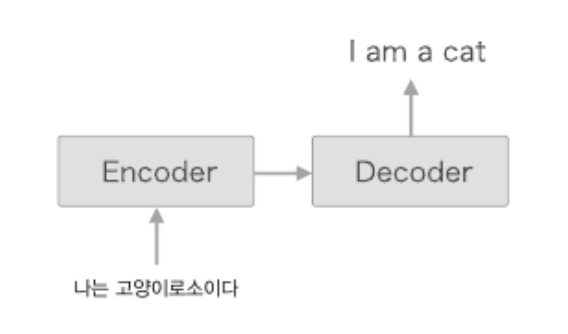

Encoder층을 구성하는 계층

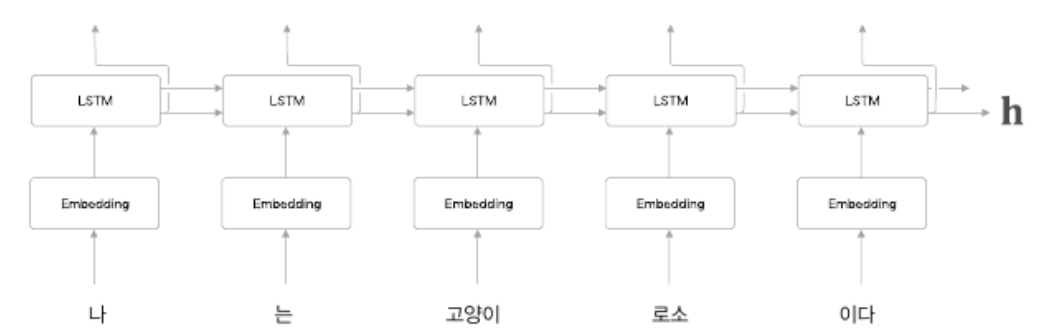

- Encoder는 RNN을 이용해 시계열 데이터 h라는 은닉상태 벡터로 변환한다.
- Encoder가 출력하는 벡터 h는 LSTM계층의 마지막 은닉 상태이다.
- 이 마지막 은닉상태 h에 문장을 번역하는 데 필요한 정보가 인코딩이다.
- 여기서 중요한 점은 LSTM의 은닉상태 h는 고정 길이 벡터라는 것이다.
- 그래서 인코딩한다라함은 결국 임의의 길이의 문장을 고정 길이 벡터로 변환하는 작업이 된다.

Decoder를 구성하는 계층

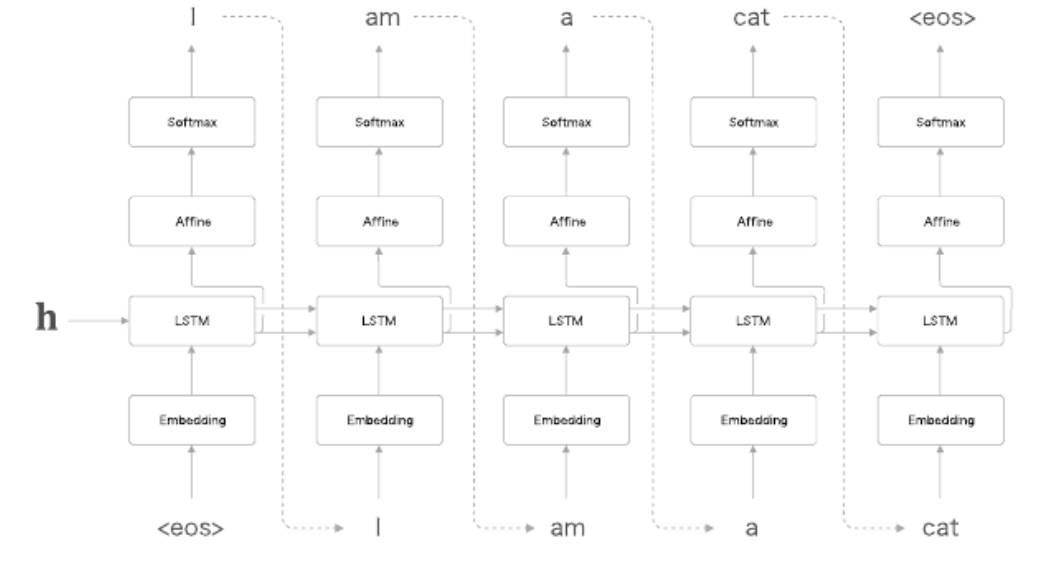

- 앞절의 신경망과 완전히 같은 구성이다. 다른 점이 있다면
- LSTM계층이 벡터 h를 입력받는다는 점이 다르다.
- 참고로, 앞 절의 언어 모델에서는 LSTM계층이 아무것도 받지 않는다.
- 이처ㅇ럼 단 하나의 사소한 차이가 평범한 언어 모델을 번역도 해낼 수 있는 Decoder로 탈바꿈 시킨다.

Decoder와 Encoder를 연결한 계층을 구성

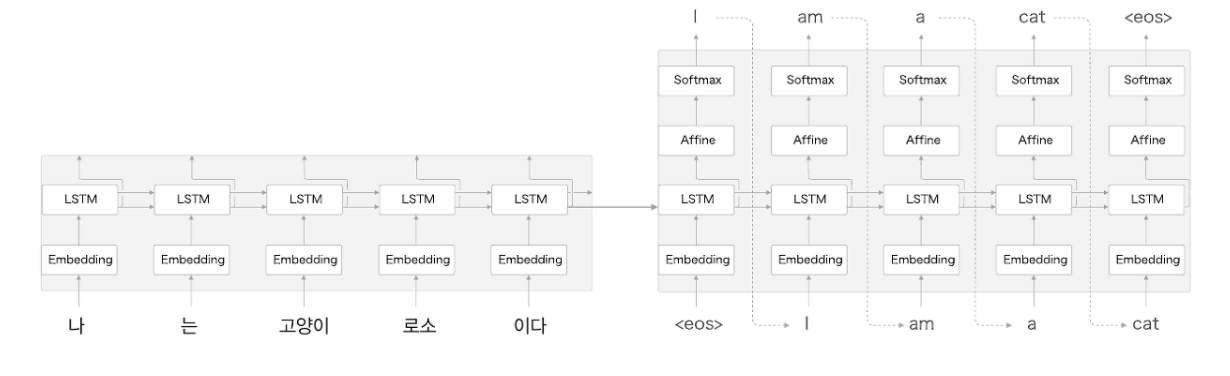

- LSTM 계층의 은닉 상태가 Encoder와 Decoder를 이어주는 가교가 된다.
- 순전파때는 Encoder에서 인코딩된 정보가 LSTM 계층의 은닉상태를 통해 Decoder에 전해진다.
- seq2seq의 역전파때는 이 가교를 통해 기울기가 Decoder로부터 Encoder로 전해진다.

### 2) 시계열 데이터 변환용 장난감 문제
> 지금까지 word2vec이나 언어 모델 등에서 문장을 단어 단위로 분할해왔다. 하지만 문장을 반드시 단어로 분할해야하는 건 아니다. 실제로 이번 문제에서는 단어가 아닌 문자 단위로 분할하려고 한다.

### 3) 가변 길이 시계열 데이터
- 우리는 덧셈을 문자(숫자)의 리스트로써 다루기로 했다. 
- 이때 주의할 점은 덧셈 문장이나 그 대답의 문자 수가 문제마다 다르다는 것이다.
- 덧셈문제에서는 샘플마다 데이터의 시간 방향 크기가 다르다. 이것을 가변 길이 시계열 데이터라고 한다.
- 따라서 신경망 학습 시 미니배치 처리를 하려면 무언가 추가 노력이 필요하다.
- 가변 길이 시계열 데이터를 미니배치로 학습하기 위한 가장 단순한 방법은 패딩을 사용하는 것이다.
- 패딩이란 원래의 데이터에 의미 없는 데이터를 채워 모든 데이터의 길이를 균일하게 맞추는 기법이다.
- 패딩을 덧셈문제에 적용해보면 모든 입력 데이터의 길이를 통일하고, 남는 공간에는 의미 없는 데이터를 채운걸 볼 수 있다.

> 이처럼 패딩을 적용해 데이터 크기를 통일시키면 가변 길이 시계열 데이터도 처리할 수 있다. 그러나 원래는 존해하지 않던 패딩용문자까지 seq2seq가 처리하게 된다. 따라서 패딩을 적용해야 하지만 정확성이 중요하다면 seq2seq에 패딩 전용 처리를 추가해야한다.

### 4) 덧셈 데이터셋

In [21]:
# coding: utf-8
import sys
sys.path.append('/content/drive')
import os
import numpy
print(os.path)

id_to_char = {}
char_to_id = {}


def _update_vocab(txt):
    chars = list(txt)

    for i, char in enumerate(chars):
        if char not in char_to_id:
            tmp_id = len(char_to_id)
            char_to_id[char] = tmp_id
            id_to_char[tmp_id] = char


def load_data(file_name, seed=1984):
    file_path = file_name

    if not os.path.exists(file_path):
        print('No file: %s' % file_name)
        return None

    questions, answers = [], []

    for line in open(file_path, 'r'):
        idx = line.find('_')
        questions.append(line[:idx])
        answers.append(line[idx:-1])

    # 어휘 사전 생성
    for i in range(len(questions)):
        q, a = questions[i], answers[i]
        _update_vocab(q)
        _update_vocab(a)

    # 넘파이 배열 생성
    x = numpy.zeros((len(questions), len(questions[0])), dtype=numpy.int)
    t = numpy.zeros((len(questions), len(answers[0])), dtype=numpy.int)

    for i, sentence in enumerate(questions):
        x[i] = [char_to_id[c] for c in list(sentence)]
    for i, sentence in enumerate(answers):
        t[i] = [char_to_id[c] for c in list(sentence)]

    # 뒤섞기
    indices = numpy.arange(len(x))
    if seed is not None:
        numpy.random.seed(seed)
    numpy.random.shuffle(indices)
    x = x[indices]
    t = t[indices]

    # 검증 데이터셋으로 10% 할당
    split_at = len(x) - len(x) // 10
    (x_train, x_test) = x[:split_at], x[split_at:]
    (t_train, t_test) = t[:split_at], t[split_at:]

    return (x_train, t_train), (x_test, t_test)


def get_vocab():
    return char_to_id, id_to_char


<module 'posixpath' from '/usr/lib/python3.7/posixpath.py'>


In [23]:
import sys
sys.path.append('/content/drive/MyDrive/인공지능/밑시딥2/')



(x_train, t_train), (x_test, t_test) = load_data('/content/drive/MyDrive/인공지능/밑시딥2/dataset/addition.txt', seed=1984)
char_to_id, id_to_char = get_vocab()

print(x_train.shape, t_train.shape)
print(x_test.shape, t_test.shape)
# (45000, 7) (45000, 5)
# (5000, 7) (5000, 5)

print(x_train[0])
print(t_train[0])
# [ 3  0  2  0  0 11  5]
# [ 6  0 11  7  5]

print(''.join([id_to_char[c] for c in x_train[0]]))
print(''.join([id_to_char[c] for c in t_train[0]]))
# 71+118
# _189


No file: /content/drive/MyDrive/인공지능/밑시딥2/dataset/addition.txt


TypeError: ignored